<a href="https://colab.research.google.com/github/rjimpervious/covid_predictor/blob/main/covid_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import tools needed
import datetime
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMAResults

from math import sqrt

import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Preparing Data

In [ ]:
df = pd.read_csv("drive/MyDrive/covid_predictor/covid_de.csv", parse_dates=["date"])

In [ ]:
df = df.groupby(by="date").sum()

In [ ]:
# Get the location of 2020/02/24 because we will use that as a starting point
base = df.index.get_loc('2020-02-24')
base


16

Now start at index 6

In [ ]:
# Get the sum of the cases until to index 16
df["cases"][:6].sum()

8

In [ ]:
# Now start at index 6
df = df[16:]

In [ ]:
df.tail()

,cases,deaths,recovered
date,,,
2021-03-31,23913,25,467
2021-04-01,21114,10,295
2021-04-02,15262,7,137
2021-04-03,9893,6,68
2021-04-04,4798,2,22


In [ ]:
# change to value of index 0 (previously index 6) to sum of the previous values
df.iloc[0] = 7

In [ ]:
del df["deaths"]

In [ ]:
del df["recovered"]

In [ ]:
df.head()

,cases
date,
2020-02-24,7
2020-02-25,3
2020-02-26,7
2020-02-27,24
2020-02-28,48


# Now plot the current DataFrame

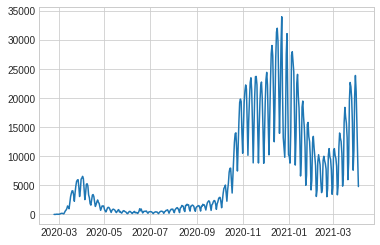

In [ ]:
plt.plot(df);

In [ ]:
# Set frequency of index as 'd' (day) ( this is required for ARIMA mode)
df = df.asfreq('d')

# GridSearch (Exhaustive Searching) the best parameters for ARIMA model

In [ ]:


# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=12125.254
ARIMA(0, 0, 1) RMSE=6622.074
ARIMA(0, 1, 0) RMSE=5009.130
ARIMA(0, 1, 1) RMSE=4028.460
ARIMA(0, 2, 0) RMSE=5543.361
ARIMA(0, 2, 1) RMSE=5482.694
ARIMA(0, 2, 2) RMSE=4045.567
ARIMA(1, 0, 0) RMSE=4927.461
ARIMA(1, 0, 1) RMSE=3887.036
ARIMA(1, 1, 0) RMSE=4657.573
ARIMA(1, 1, 1) RMSE=4164.819
ARIMA(1, 2, 0) RMSE=5552.453
ARIMA(2, 0, 0) RMSE=4453.950
ARIMA(2, 0, 1) RMSE=4027.889
ARIMA(2, 1, 0) RMSE=3819.030
ARIMA(2, 1, 1) RMSE=3336.026
ARIMA(2, 2, 0) RMSE=4868.597
ARIMA(4, 0, 0) RMSE=3795.577
ARIMA(4, 1, 0) RMSE=3019.502
ARIMA(4, 1, 1) RMSE=2701.078
ARIMA(4, 2, 0) RMSE=4533.374
ARIMA(6, 0, 0) RMSE=2368.052
Best ARIMA(6, 0, 0) RMSE=2368.052


# Now test the models with the best parameters

predicted=21123.196877, expected20354.000000
predicted=23008.618886, expected23705.000000
predicted=24251.823400, expected23752.000000
predicted=21273.798283, expected22306.000000
predicted=16050.873366, expected14791.000000
predicted=11048.376544, expected8851.000000
predicted=11114.201250, expected15095.000000
predicted=21946.556714, expected19448.000000
predicted=21864.980222, expected22085.000000
predicted=24043.030181, expected22782.000000
predicted=20620.559798, expected20146.000000
predicted=13765.562808, expected14937.000000
predicted=12808.029840, expected8798.000000
predicted=10641.347974, expected13328.000000
predicted=19211.958696, expected19254.000000
predicted=22558.846629, expected23203.000000
predicted=23513.261625, expected24453.000000
predicted=21726.856234, expected22292.000000
predicted=15321.891863, expected15720.000000
predicted=11616.784212, expected10260.000000
predicted=11865.208953, expected16469.000000
predicted=22042.837602, expected22838.000000
predicted=25

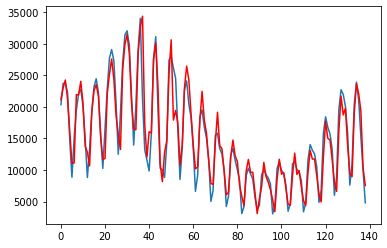

In [ ]:


X = df.values
size = int(len(X)*0.66)
train, test = X[0:size], X[size: len(X)]
history = [x for x in train]
predictions = []
#walk forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(6, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
    print('predicted=%f, expected%f' %(yhat, obs))

# evaluate forecasts
warnings.filterwarnings("ignore")
rmse = sqrt(mean_squared_error(test, predictions))
print("Test RMSE: {:.3f}".format(rmse))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#Now fit the model with the best parameters

In [ ]:
model = ARIMA(df, order=(6, 0, 0))

In [ ]:
model_fit = model.fit()

# Now Make predictions

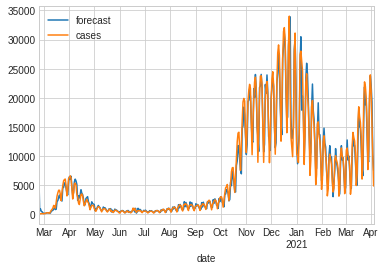

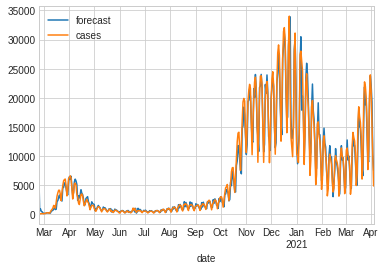

In [ ]:
model_fit.plot_predict()

In [ ]:
# Make a 14 day forecast
forecast = model_fit.forecast(steps=14)[0]
forecast

array([ 8808.59912855, 17923.56097024, 22662.52327115, 20459.54597598,
       15831.27241979,  9869.62776891,  6146.39069533,  9341.26666395,
       16850.83539448, 21115.97503394, 20097.20987994, 15830.52585071,
       10292.14960685,  7115.89463767])

In [ ]:
df.tail()

,cases
date,
2021-03-31,23913
2021-04-01,21114
2021-04-02,15262
2021-04-03,9893
2021-04-04,4798


In [ ]:
# Making forecast dataframe
forecast_dates = pd.date_range(start='2021-04-05', periods=14, freq='d')
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=["cases"])

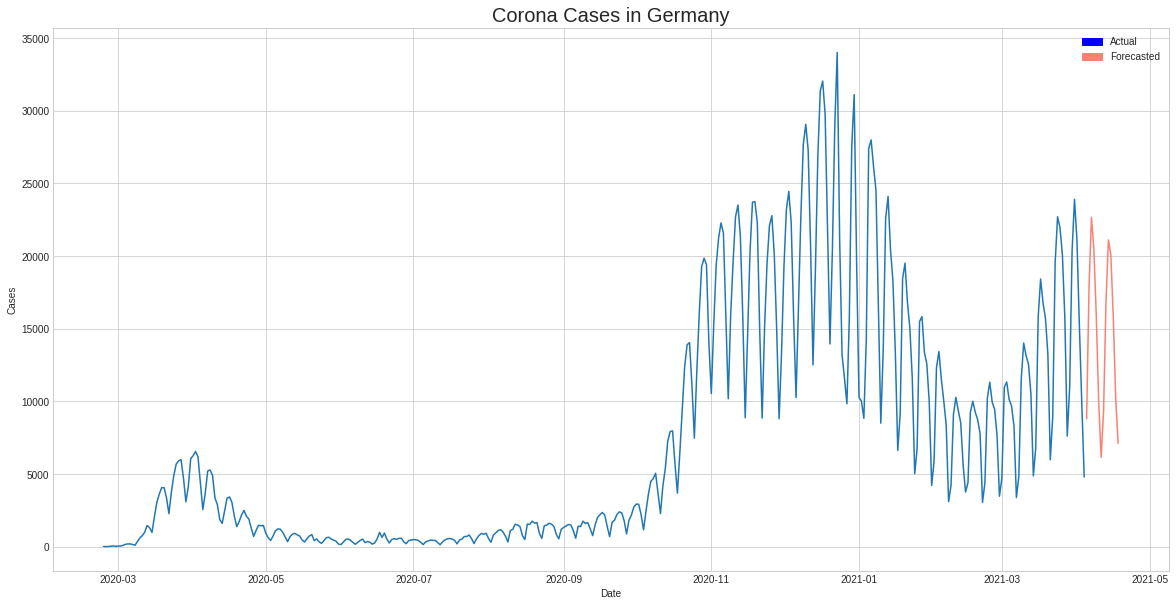

In [ ]:
import matplotlib.patches as mpatches
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(20, 10))
plt.plot(df)
plt.plot(forecast_df, color="salmon");

plt.xlabel("Date", fontsize=10)
plt.ylabel("Cases", fontsize=10)
plt.title("Corona Cases in Germany", fontsize=20)

actual = mpatches.Patch(color='blue', label='Actual')
forecasted = mpatches.Patch(color='salmon', label='Forecasted')
plt.legend(handles=[actual, forecasted]);



In [ ]:
model_fit.save("drive/MyDrive/covid_predictor/models/model.pkl")

In [ ]:
df.head()

,cases
date,
2020-02-24,7
2020-02-25,3
2020-02-26,7
2020-02-27,24
2020-02-28,48


In [ ]:
df.to_pickle("drive/MyDrive/covid_predictor/dataframe.pkl")

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']